
# <p style="font-family: 'Amiri'; font-size: 3rem; color: Black; text-align: center; margin: 0; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3); background-color: #c9b68b; padding: 20px; border-radius: 20px; border: 7px solid Black; width:95%"> 1 | Installing Libraries </p>

In [43]:

    !pip install /kaggle/input/onnxruntime/humanfriendly-10.0-py2.py3-none-any.whl --no-index --find-links /kaggle/input/onnxruntime
    !pip install /kaggle/input/onnxruntime/coloredlogs-15.0.1-py2.py3-none-any.whl --no-index --find-links /kaggle/input/onnxruntime
    !pip install /kaggle/input/onnxruntime/onnxruntime-1.17.3-cp310-cp310-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl --no-index --find-links /kaggle/input/onnxruntime

Looking in links: /kaggle/input/onnxruntime
Processing /kaggle/input/onnxruntime/humanfriendly-10.0-py2.py3-none-any.whl
humanfriendly is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Looking in links: /kaggle/input/onnxruntime
Processing /kaggle/input/onnxruntime/coloredlogs-15.0.1-py2.py3-none-any.whl
coloredlogs is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Looking in links: /kaggle/input/onnxruntime
Processing /kaggle/input/onnxruntime/onnxruntime-1.17.3-cp310-cp310-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl
onnxruntime is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


# <p style="font-family: 'Amiri'; font-size: 3rem; color: Black; text-align: center; margin: 0; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3); background-color: #c9b68b; padding: 20px; border-radius: 20px; border: 7px solid Black; width:95%">2 | Importing Libraries </p>

In [44]:
import os
import gc
import sys
import glob
import time
import shutil
import random
import ast

import warnings
warnings.simplefilter("ignore")
import onnx
import onnxruntime as ort
import wandb

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GroupKFold, StratifiedGroupKFold
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn import metrics
from sklearn.metrics import mean_squared_error, roc_auc_score
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from torch.cuda import amp
import torch
print(f"pytorch version is {torch.__version__}")
import torch.nn as nn
from torch.cuda import amp

isTrain = False
name = 'bird2024exp1057'

import torchvision
from torchvision.transforms import v2 as transforms

import librosa
import torchaudio
import torchaudio.transforms as audioT

import timm

pytorch version is 2.1.2+cpu


# <p style="font-family: 'Amiri'; font-size: 3rem; color: Black; text-align: center; margin: 0; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3); background-color: #c9b68b; padding: 20px; border-radius: 20px; border: 7px solid Black; width:95%">3 | Configuration Class </p>



---

In [45]:
class config:
    dir = "/kaggle/input/birdclef-2024/"


    wave_path = "original_waves/second_30/"

    model_name = 'tf_efficientnet_b0'

    pool_type = 'avg'

    
    train_duration = 30 
    slice_duration = 5 

    test_duration = 5

    train_drop_duration = 1
    
    # spectrogram parameters
    sr = 32000
    fmin = 20
    fmax = 15000

    n_mels = 128
    n_fft = n_mels*8
    size_x = 512
    
    hop_length = int(sr*slice_duration / size_x)
    test_hop_length = int(sr*test_duration / size_x)
    
    bins_per_octave = 12

    nfolds = 5
    inference_folds = [4]
    
    enable_amp = True
    train_batchsize = 32
    valid_batchsize = 1

    # loss_type = "BCEWithLogitsLoss"
    loss_type = "BCEFocalLoss"

    lr = 1.0e-04 


    optimizer='adan'
    weight_decay = 1.0e-02
    es_patience =  5
    deterministic = True
    enable_amp = True

    max_epoch = 9
    aug_epoch = 6
    

    useSecondary =True
    secondary_label_value = 0.5
    oversample =False
    oversample_threthold = 60
    
    seed = 42

    wandb = True

    ###augmentation flags
    aug_noise            = 0.
    aug_gain             = 0.0
    aug_wave_pitchshift  = 0.0
    aug_wave_shift       = 0.

    aug_spec_xymasking   = 0.
    aug_spec_coarsedrop  = 0.
    aug_spec_hflip       = 0.

    ##mixup param
    aug_wave_mixup       = 1.0
    aug_spec_mixup       = 0.0
    aug_spec_mixup_prob  = 0.5 
    alpha=0.95

    smoothing_value      = 0.0
    # spec_mix_mask_percent = 20
    
cfg = config()

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

print(device)

cpu


# <p style="font-family: 'Amiri'; font-size: 3rem; color: Black; text-align: center; margin: 0; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3); background-color: #c9b68b; padding: 20px; border-radius: 20px; border: 7px solid Black; width:95%">4 | Data Augmentation Pipeline For Training </p>

In [46]:
if isTrain== True:

    normal_augment = Compose([
        OneOf([
            Gain(min_gain_in_db=-15, max_gain_in_db=15, p=1.0),
            GainTransition(min_gain_in_db=-24.0, max_gain_in_db=6.0,
                           min_duration=0.2, max_duration=6.0,  p=1.0)
        ], p=cfg.aug_gain),
        
        OneOf([
            AddGaussianNoise(p=1),
            AddColorNoise(p=1, min_snr_db=5, max_snr_db=20, min_f_decay=-3.01, max_f_decay=-3.01)
        ],p=cfg.aug_noise),

    
        PitchShift(min_semitones=-1, max_semitones=1, p=cfg.aug_wave_pitchshift),
        Shift(p=cfg.aug_wave_shift)
    ])
    alb_transform = [
        albumentations.XYMasking(num_masks_x=2, num_masks_y=1, 
                                 mask_x_length=cfg.size_x//30, mask_y_length=cfg.n_mels//30,
                                 fill_value=0, mask_fill_value=0, p=cfg.aug_spec_xymasking),
        albumentations.CoarseDropout(fill_value=0, min_holes=20, max_holes=50, p=cfg.aug_spec_coarsedrop),
        albumentations.HorizontalFlip(p=cfg.aug_spec_hflip)    
    ]
    albumentations_augment = albumentations.Compose(alb_transform)

# <p style="font-family: 'Amiri'; font-size: 3rem; color: Black; text-align: center; margin: 0; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3); background-color: #c9b68b; padding: 20px; border-radius: 20px; border: 7px solid Black; width:95%">5 |  Mixup Data Augmentation Function </p>


In [47]:
def mixup(data, targets, alpha, mode="same_wave"):
    
    if mode == "same_wave":
        data = torch.tensor(data)
        indices = torch.randperm(data.size(0))
        shuffled_data = data[indices]

        lam = np.random.beta(alpha, alpha)
        new_data = data * lam + shuffled_data * (1 - lam)
        return new_data.numpy()
        
    elif mode == "other_wave":
        indices = torch.randperm(data.size(0))
        shuffled_data = data[indices]
        shuffled_targets = targets[indices]
    
        lam = np.random.beta(alpha, alpha)
        new_data = data * lam + shuffled_data * (1 - lam)
        new_targets = targets * lam + shuffled_targets * (1 - lam)
    
        return new_data, new_targets

# <p style="font-family: 'Amiri'; font-size: 3rem; color: Black; text-align: center; margin: 0; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3); background-color: #c9b68b; padding: 20px; border-radius: 20px; border: 7px solid Black; width:95%">6 | Spectral Mixup Function</p>





---

In [48]:
if isTrain== True:
    spec_xymasking = albumentations.XYMasking(num_masks_x=2, num_masks_y=1, 
                                              mask_x_length=cfg.size_x // 10, mask_y_length=cfg.n_mels // 10,
                                              fill_value=0, mask_fill_value=0, p=1)

def spec_mixup(data, targets):
    type = data.dtype

    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    data = np.array(data)
    data_transposed = np.transpose(data, (2, 3, 1, 0))
    data_transposed = spec_xymasking(image=data_transposed)["image"]
    data_transposed = np.transpose(data_transposed, (3, 2, 0, 1))  

    diff = data - data_transposed
    mask = (diff != 0).astype(int)

    shuffled_data_masked = (shuffled_data * mask)

    new_data = torch.tensor(data_transposed, dtype=type) + torch.tensor(shuffled_data_masked, dtype=type)

    lam = mask.sum() / len(data) / (cfg.n_mels*cfg.size_x)
    new_targets = targets * (1-lam) + shuffled_targets *lam

    return new_data, new_targets


# <p style="font-family: 'Amiri'; font-size: 3rem; color: Black; text-align: center; margin: 0; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3); background-color: #c9b68b; padding: 20px; border-radius: 20px; border: 7px solid Black; width:95%">7 | Mel Spectrogram Generation </p>



In [49]:
spec_layer = torchaudio.transforms.MelSpectrogram(
    sample_rate=cfg.sr, hop_length=cfg.hop_length, n_fft=cfg.n_fft,
    n_mels=cfg.n_mels,f_min=cfg.fmin,f_max=cfg.fmax,mel_scale='slaney',center=True, pad_mode='reflect'
).to(device)

valid_spec_layer = torchaudio.transforms.MelSpectrogram(
    sample_rate=cfg.sr, hop_length=cfg.test_hop_length, n_fft=cfg.n_fft,
    n_mels=cfg.n_mels,f_min=cfg.fmin,f_max=cfg.fmax,mel_scale='slaney',center=True, pad_mode='reflect'
).to(device)

test_spec_layer = torchaudio.transforms.MelSpectrogram(
    sample_rate=cfg.sr, hop_length=cfg.test_hop_length, n_fft=cfg.n_fft,
    n_mels=cfg.n_mels,f_min=cfg.fmin,f_max=cfg.fmax,mel_scale='slaney',center=True, pad_mode='reflect'
).cpu()

# <p style="font-family: 'Amiri'; font-size: 3rem; color: Black; text-align: center; margin: 0; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3); background-color: #c9b68b; padding: 20px; border-radius: 20px; border: 7px solid Black; width:95%">8 | Data Preparation Steps</p>


 


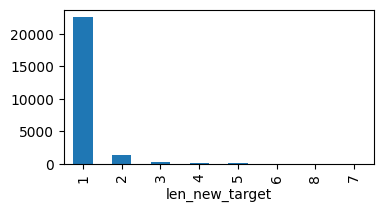

In [50]:
sample_submission = pd.read_csv(cfg.dir+"sample_submission.csv")
LABELS = list(sample_submission.set_index("row_id").columns)
LABELS[:5]
train_csv = pd.read_csv(cfg.dir+"train_metadata.csv")
train_csv['new_target'] = train_csv['primary_label'] + ' ' + train_csv['secondary_labels'].map(lambda x: ' '.join(ast.literal_eval(x)))
train_csv['len_new_target'] =train_csv['new_target'].map(lambda x: len(x.split()))
train_csv["len_new_target"].value_counts().plot(kind="bar", figsize=(4,2))
train_csv["filename_tmp"] = train_csv["filename"].map(lambda x:x.split("/")[1][:-4])
duplicated_filenames = train_csv["filename_tmp"].value_counts()[train_csv["filename_tmp"].value_counts() > 1].index
train_csv = train_csv[~train_csv["filename_tmp"].isin(duplicated_filenames)]
train_csv = train_csv.reset_index(drop=True)

# <p style="font-family: 'Amiri'; font-size: 3rem; color: Black; text-align: center; margin: 0; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3); background-color: #c9b68b; padding: 20px; border-radius: 20px; border: 7px solid Black; width:95%"> 9 | BirdCLEF Dataset Preparation </p>



In [51]:
class BirdCLEF_Dataset(torch.utils.data.Dataset):
    def __init__(self, df, augmentation=False, mode='train'):
        if mode == 'train':
            self.df = df.reset_index(drop=True)
        elif mode == 'valid':
            self.df = df.reset_index(drop=True)
        else:
            self.df = df
        self.mode = mode
        self.augmentation = augmentation
    
    def __len__(self):
        return len(self.df)

    def normalize(self, x):
        valid_values = x[x != float('-inf')]
        mean_value = np.mean(valid_values)
        x[x == float('-inf')] = mean_value
        

        x = x - x.min()
        x = x / x.max()
        return x

    def wave_tile_and_cutoff(self, data):
      
        drop_duration = cfg.sr*cfg.train_drop_duration
        use_duration  = cfg.sr*cfg.train_duration
        
        if len(data[0]) > drop_duration: 
            data = data[:,drop_duration:]

        if len(data[0]) < use_duration:
            iter = 1 + (use_duration) // len(data[0])
            data = np.tile(data, (1, iter))

        data = data[:,:use_duration]
        return data

    def label_smoothing(self, idx, target):
    
        secondary_target = target * cfg.secondary_label_value
    
        out_of_target_noise_intensity = cfg.smoothing_value/(len(LABELS)-1) 
        out_of_target_noise_array = torch.ones(target.shape) * out_of_target_noise_intensity
        
        secondary_target_with_noise = secondary_target + out_of_target_noise_array
        secondary_target_with_noise = torch.clip(secondary_target_with_noise, min=0, max=cfg.secondary_label_value)
    
        primary_target = np.isin(LABELS, self.df.loc[idx, "primary_label"]).astype(int)
        primary_target = torch.tensor(primary_target, dtype=torch.float32)

        primary_and_secondary_target_with_noise = primary_target + secondary_target_with_noise
        new_target = torch.clip(primary_and_secondary_target_with_noise, min=0, max=1)
    
        new_target = new_target - primary_target * cfg.smoothing_value
    
        return new_target

    
    def __getitem__(self, idx):

        if self.mode == 'train':

          
            if cfg.useSecondary == True:
                target = np.isin(LABELS, self.df.loc[idx, "new_target"].split()).astype(int)
            else:
                target = np.isin(LABELS, self.df.loc[idx, "primary_label"].split()).astype(int)
            target = torch.tensor(target, dtype=torch.float32)
          
            target = self.label_smoothing(idx, target)
            
            fileID = self.df.loc[idx, 'fileID'] 
            
            path = f"{cfg.wave_path}{fileID}.npy"
            wave = np.load(path)
            

      
            wave = self.wave_tile_and_cutoff(data=wave)

            
            input_duration = cfg.sr * cfg.slice_duration
            
            
            if self.augmentation == True:
               
                if cfg.aug_wave_mixup > np.random.random():
                    #train_duration -> slice_duration
                    wave_reshape = wave.reshape(-1, input_duration)
                    wave = mixup(data=wave_reshape, targets=target, alpha=cfg.alpha, mode="same_wave")
                    wave = wave[:1,:]
                else:
                    wave = wave[:, :input_duration]
                
     
                wave = normal_augment(samples=wave, sample_rate=cfg.sr)

    
                wave = torch.tensor(wave).to(device)
                mel_spec = spec_layer(wave)
                mel_spec = np.array(mel_spec.cpu())

                mel_spec = np.log(mel_spec)
                for i in range(len(mel_spec)):
                    mel_spec[i] = self.normalize(mel_spec[i])
                mel_spec = torch.tensor(mel_spec)
                mel_spec = mel_spec[:,:,:cfg.size_x]

     
                mel_spec = np.array(mel_spec.cpu())
                mel_spec = np.transpose(mel_spec, (1, 2, 0))                
                mel_spec = albumentations_augment(image=mel_spec)["image"]
                mel_spec = np.transpose(mel_spec, (2, 0, 1))


                
            else:
                wave = wave[:, :input_duration]
                
                wave = torch.tensor(wave).to(device)
                mel_spec = spec_layer(wave)
                mel_spec = np.array(mel_spec.cpu())

                mel_spec = np.log(mel_spec)

                for i in range(len(mel_spec)):
                    mel_spec[i] = self.normalize(mel_spec[i])
                    

                mel_spec = torch.tensor(mel_spec)
                mel_spec = mel_spec[:,:,:cfg.size_x]

            
            mel_spec = torch.tensor(mel_spec)

            
            return mel_spec, target

        elif self.mode == 'valid':
            

            if cfg.useSecondary == True:
                target = np.isin(LABELS, self.df.loc[idx, "new_target"].split()).astype(int)
            else:
                target = np.isin(LABELS, self.df.loc[idx, "primary_target"].split()).astype(int)
            target = torch.tensor(target, dtype=torch.float32)
            
            fileID = self.df.loc[idx, 'fileID'] 
            
            path = f"{cfg.wave_path}{fileID}.npy"
            wave = np.load(path)

            wave = self.wave_tile_and_cutoff(data=wave)

            input_duration = cfg.sr*cfg.test_duration
            wave_reshape = wave.reshape(-1, input_duration)

            wave_reshape = torch.tensor(wave_reshape).to(device)
            mel_specs = valid_spec_layer(wave_reshape)
            mel_specs = mel_specs.cpu().numpy()

            mel_specs = np.log(mel_specs)
            for i in range(len(mel_specs)):
                mel_specs[i] = self.normalize(mel_specs[i])
            mel_specs = torch.tensor(mel_specs)
            
            mel_specs = mel_specs[:,:,:cfg.size_x]

            targets = torch.tile(target, dims=(mel_specs.shape[0],1))
            return mel_specs, targets

        elif self.mode == 'test':

            filepath = self.df[idx]
            wave, _  = torchaudio.load(filepath)
            wave = wave[:,:60*4*32000]

            wave_reshaped = wave.reshape(-1, 1, cfg.test_duration*cfg.sr)
            
            mel_spec = test_spec_layer(wave_reshaped)
            mel_spec = np.log(mel_spec)

            mel_spec = np.array(mel_spec)
            for i in range(len(mel_spec)):
                mel_spec[i] = self.normalize(mel_spec[i])
            mel_spec = torch.tensor(mel_spec)

            mel_spec = mel_spec[:,:,:cfg.size_x]
            return mel_spec

        elif self.mode == 'clean':

            filepath = self.df[idx]
            wave, _  = torchaudio.load(filepath)

            wave = wave[:, :6*cfg.test_duration*cfg.sr]

            chunk_length = len(wave[0]) // (cfg.test_duration*cfg.sr)
            
            wave = wave[:,:chunk_length*cfg.test_duration*cfg.sr]

            wave_reshaped = wave.reshape(-1, 1, cfg.test_duration*cfg.sr)
            
            mel_spec = test_spec_layer(wave_reshaped)
            mel_spec = np.log(mel_spec)

            mel_spec = np.array(mel_spec)
            for i in range(len(mel_spec)):
                mel_spec[i] = self.normalize(mel_spec[i])
            mel_spec = torch.tensor(mel_spec)

            return mel_spec, filepath

In [52]:
if isTrain:
    print("train data")
    dataset = BirdCLEF_Dataset(df=train_csv, augmentation=True,  mode="train")
    data, target = dataset[270]
    fig, ax = plt.subplots(figsize=(6,4))
    plt.imshow(data[0], cmap="jet", origin="lower")
    plt.show()
    
    print("validation data")
    dataset = BirdCLEF_Dataset(df=train_csv, augmentation=True,  mode="valid")
    data, target = dataset[270]
    fig, axes = plt.subplots(figsize=(12,8), nrows=len(data), tight_layout=True)
    for idx, ax in enumerate(axes.ravel()):
        ax.imshow(data[idx], cmap="jet", origin="lower")

# <p style="font-family: 'Amiri'; font-size: 3rem; color: Black; text-align: center; margin: 0; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3); background-color: #c9b68b; padding: 20px; border-radius: 20px; border: 7px solid Black; width:95%">10 | BirdModel : Flexible Pooling Architecture For Bird Sound Classification </p>





In [53]:
class BirdModel(torch.nn.Module):
    def __init__(self, model_name, pretrained, in_channels, num_classes, pool="default"):
        super().__init__()

        self.pool = pool
        self.normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        if pool == "default":
            self.backbone = timm.create_model(
                model_name=model_name, pretrained=pretrained,
                num_classes=0, in_chans=3)
        else:
            self.backbone = timm.create_model(
                model_name=model_name, pretrained=pretrained,
                num_classes=0, in_chans=3, global_pool="")

        in_features = self.backbone.num_features



        self.max_pooling = torch.nn.Sequential(torch.nn.AdaptiveMaxPool2d(1),
                                               torch.nn.Flatten(start_dim=1, end_dim=-1))
        self.avg_pooling = torch.nn.Sequential(torch.nn.AdaptiveAvgPool2d(1),
                                               torch.nn.Flatten(start_dim=1, end_dim=-1))
        self.both_pooling_neck = torch.nn.Sequential(torch.nn.BatchNorm1d(2*in_features),
                                                     torch.nn.Linear(in_features=2*in_features, out_features=in_features))
        
        self.head = torch.nn.Sequential(
            torch.nn.BatchNorm1d(in_features),
            torch.nn.Linear(in_features=in_features, out_features=256),
            torch.nn.Hardswish(inplace=True),torch.nn.Dropout(0.1),
            torch.nn.Linear(in_features=256, out_features=len(LABELS))  
        )



        self.active = torch.nn.Sigmoid()
    def forward(self, x):
        x = x.expand(-1, 3, -1, -1)
        x = self.normalize(x)
        x = self.backbone(x)

        if self.pool == "max":
            x = self.max_pooling(x)
        elif self.pool == "avg":
            x = self.avg_pooling(x)
        elif self.pool == "both":
            x_max = self.max_pooling(x)
            x_avg = self.avg_pooling(x)
            x = x_max + x_avg
            # x = torch.cat([x_max, x_avg], dim=1)
            # x = self.both_pooling_neck(x)
            
        x = self.head(x)
        # x = self.active(x)
        return x

# <p style="font-family: 'Amiri'; font-size: 3rem; color: Black; text-align: center; margin: 0; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3); background-color: #c9b68b; padding: 20px; border-radius: 20px; border: 7px solid Black; width:95%">11 | Stratified k-Fold Cross-Validation and Random Seed Setting 🐦</p>


1. **Stratified K-Fold Cross-Validation**:
   - Stratified K-Fold cross-validation is a technique used to evaluate the performance of a machine learning model. It ensures that each fold of the dataset has approximately the same proportion of samples from each class, which is particularly useful for imbalanced datasets.
   - `StratifiedKFold` is a class from the scikit-learn library that splits a dataset into K folds while preserving the percentage of samples for each class.
   - In the `for` loop:
       - `skf.split(train_csv, train_csv['primary_label'])` splits the dataset (`train_csv`) into train and validation sets for each fold, ensuring that each fold maintains the same distribution of classes as the original dataset.
       - `train_index` and `valid_index` contain the indices of samples for the training and validation sets for the current fold.
       - `enumerate(skf.split(...))` iterates over each fold, providing the fold index (`fold`) and the corresponding train/validation indices.
       - `train_csv.loc[valid_index, 'fold'] = int(fold)` assigns the fold index to the validation samples in the `fold` column of the DataFrame `train_csv`, indicating which fold each sample belongs to.

2. **Random Seed Setting**:
   - Setting random seeds ensures reproducibility of results in machine learning experiments. It initializes the random number generators with a fixed seed, so the same sequence of random numbers is generated every time the code is run.
   - `set_random_seed` is a function defined to set the random seed across different random number generators used in the experiment.
   - Inside the function:
       - `random.seed(seed)`, `np.random.seed(seed)`, and `os.environ["PYTHONHASHSEED"] = str(seed)` set the random seed for the Python built-in random number generator, NumPy, and hash randomization, respectively.
       - `torch.manual_seed(seed)` sets the random seed for the PyTorch library for CPU operations.
       - `torch.cuda.manual_seed(seed)` sets the random seed for GPU operations in PyTorch.
       - `torch.backends.cudnn.deterministic = deterministic` ensures deterministic behavior of CuDNN (CUDA Deep Neural Network library) for GPU operations in PyTorch, which can affect the performance but ensures reproducibility.



In [54]:

skf = StratifiedKFold(n_splits=cfg.nfolds, shuffle=True, random_state=cfg.seed)
for fold, (train_index, valid_index) in enumerate(skf.split(train_csv, train_csv['primary_label'])):
    train_csv.loc[valid_index, 'fold'] = int(fold)
    
    
if isTrain:
    train_csv.groupby("fold", as_index=False)["primary_label"].value_counts()   
    
    
def set_random_seed(seed: int = 42, deterministic: bool = False):
    """Set seeds"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = deterministic  # type: ignore    

# <p style="font-family: 'Amiri'; font-size: 3rem; color: Black; text-align: center; margin: 0; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3); background-color: #c9b68b; padding: 20px; border-radius: 20px; border: 7px solid Black; width:95%"> 12 | BCEFocalLoss: Binary Cross-Entropy Focal Loss 🐦</p>


1. **BCEFocalLoss Class**:
    - This class defines a custom loss function called `BCEFocalLoss` for binary classification tasks.
    - It inherits from `nn.Module`, indicating that it's a PyTorch module.

2. **Initialization**:
    - The `__init__` method initializes the loss function with two parameters: `alpha` and `gamma`.
    - `alpha` (default value: 0.25) controls the balance between positive and negative class samples in the loss calculation.
    - `gamma` (default value: 2.0) controls the degree of focus on hard-to-classify examples.

3. **Forward Method**:
    - The `forward` method computes the loss given model predictions (`preds`) and ground truth labels (`targets`).
    - It first calculates the binary cross-entropy (BCE) loss using `nn.BCEWithLogitsLoss` with the option `reduction='none'` to compute the loss per sample without averaging.
    - `probas = torch.sigmoid(preds)` computes the sigmoid activation of the model predictions to obtain probabilities.

4. **Focal Loss Components**:
    - Focal loss introduces two additional components: focal term (`tmp`) and smooth term (`smp`).
    - `tmp` calculates the focal loss for positive class samples, where the focus is increased for misclassified samples (`(1. - probas)**self.gamma` increases the loss for hard-to-classify examples).
    - `smp` calculates the focal loss for negative class samples, focusing on correctly classified samples (`probas**self.gamma` increases the loss for hard-to-classify examples).
    - Both `tmp` and `smp` are multiplied by the BCE loss to incorporate the original loss calculation.

5. **Final Loss Calculation**:
    - The final loss is calculated as the sum of `tmp` and `smp`, followed by taking the mean over all samples.
    - This mean loss value is returned as the output of the `forward` method.



In [55]:
class BCEFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, preds, targets):
        bce_loss = nn.BCEWithLogitsLoss(reduction='none')(preds, targets)
        probas = torch.sigmoid(preds)

        

        tmp = targets * self.alpha * (1. - probas)**self.gamma * bce_loss
        smp = (1. - targets) * probas**self.gamma * bce_loss
        
        loss = tmp + smp
        loss = loss.mean()
        return loss

# <p style="font-family: 'Amiri'; font-size: 3rem; color: Black; text-align: center; margin: 0; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3); background-color: #c9b68b; padding: 20px; border-radius: 20px; border: 7px solid Black; width:95%">13 | Initialization Function For Training </p>

1. **Model Initialization**:
   - The function initializes the neural network model using the `BirdModel` class, which is customized for bird sound classification.
   - It sets parameters such as the model architecture (`model_name`), whether to use pre-trained weights (`pretrained`), number of input channels (`in_channels`), number of output classes (`num_classes`), and pooling type (`pool`).

2. **Optimizer Selection**:
   - Depending on the configuration (`cfg.optimizer`), the function selects the optimizer for training.
   - If `cfg.optimizer` is set to `'adan'`, it uses the custom optimizer `Adan` with specific parameters like learning rate (`lr`), betas, and weight decay.
   - Otherwise, it uses the standard AdamW optimizer from PyTorch with parameters such as learning rate (`lr`) and weight decay.

3. **Learning Rate Scheduler**:
   - The function initializes a learning rate scheduler using `torch.optim.lr_scheduler.OneCycleLR`.
   - This scheduler adjusts the learning rate during training, starting from an initial value (`cfg.lr`), and following a one-cycle policy with specified parameters such as the maximum number of epochs (`cfg.max_epoch`), percentage of epochs to increase/decrease learning rate (`pct_start`), and step size (`steps_per_epoch`).

4. **Gradient Scaler (Automatic Mixed Precision)**:
   - Automatic Mixed Precision (AMP) is a technique that combines single and half-precision floating-point arithmetic to speed up training while maintaining numerical stability.
   - The function initializes a gradient scaler using `amp.GradScaler` with the option to enable or disable AMP based on the configuration (`cfg.enable_amp`).

5. **Loss Function Initialization**:
   - Depending on the loss type specified in the configuration (`cfg.loss_type`), the function initializes the loss function.
   - If `cfg.loss_type` is set to `"BCEWithLogitsLoss"`, it uses the binary cross-entropy loss with logits (`torch.nn.BCEWithLogitsLoss`).
   - If `cfg.loss_type` is set to `"BCEFocalLoss"`, it uses the custom focal loss function `BCEFocalLoss` with a specified `alpha` value.

6. **Returning Initialized Components**:
   - The function returns the initialized model, optimizer, scheduler, scaler, and loss function, all moved to the appropriate device (`device`), typically GPU.



In [56]:
def initialization():
    model = BirdModel(model_name=cfg.model_name, pretrained=True, in_channels=3, num_classes=len(LABELS), pool=cfg.pool_type)
    
    if cfg.optimizer=='adan':
        optimizer = Adan(model.parameters(), lr=cfg.lr, betas=(0.02, 0.08, 0.01), weight_decay=cfg.weight_decay)
    else:
        optimizer = torch.optim.AdamW(params=model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer, epochs=cfg.max_epoch,
        pct_start=0.0, steps_per_epoch=len(train_dataloader),
        max_lr=cfg.lr, div_factor=25, final_div_factor=4.0e-01
    )
    
    scaler = amp.GradScaler(enabled=cfg.enable_amp)
    if cfg.loss_type == "BCEWithLogitsLoss":
        loss_func = torch.nn.BCEWithLogitsLoss()
    elif cfg.loss_type == "BCEFocalLoss":
        loss_func = BCEFocalLoss(alpha=1)
    
    


    return model.to(device), optimizer, scheduler, scaler, loss_func.to(device)

# <p style="font-family: 'Amiri'; font-size: 3rem; color: Black; text-align: center; margin: 0; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3); background-color: #c9b68b; padding: 20px; border-radius: 20px; border: 7px solid Black; width:95%">14 | Training And Evaluation Functions 🐦</p>

1. **`train_one_loop` Function**:
   - This function performs one epoch of training.
   - It iterates through the training data (`dataloader`) and updates the model parameters based on the calculated loss.
   - Within each iteration:
     - The data and labels are moved to the appropriate device (`device`).
     - The gradients are zeroed using `optimizer.zero_grad()` to clear the previous gradients.
     - Inside the training loop, gradient scaling is applied using AMP (Automatic Mixed Precision) to improve numerical stability and speed up training.
     - The loss is computed using the specified loss function (`loss_fn`) and backpropagated through the network.
     - The optimizer's learning rate is adjusted using the scheduler (`scheduler.step()`).
     - The loss value is accumulated for monitoring training progress.
   - After processing all batches, the average training loss is calculated and logged (if using Weights & Biases for logging).

2. **`mixup_one_loop` Function**:
   - This function performs one epoch of training with mixup augmentation.
   - Mixup is a data augmentation technique that blends pairs of examples and their corresponding labels.
   - It follows a similar structure to `train_one_loop`, but before feeding the data to the model, it applies mixup augmentation based on a probability threshold (`cfg.aug_spec_mixup_prob`).
   - Mixup can be applied either on different waveforms (`"other_wave"`) or on spectrograms (`"spec_mixup"`).
   - The rest of the process, including loss computation and optimization, remains the same.

3. **`evaluate_validation` Function**:
   - This function evaluates the model on the validation dataset (`dataloader`) after each epoch of training.
   - It calculates validation loss and various evaluation metrics such as AUC (Area Under the ROC Curve), F1-score, precision, and more.
   - Inside the evaluation loop:
     - The model makes predictions on the validation data.
     - Predictions are compared with the ground truth labels to compute the evaluation metrics.
     - The validation loss is computed using the specified loss function.
   - The function returns the validation loss and evaluation metrics, which can be used for monitoring the model's performance during training.

These functions collectively handle the training and evaluation process of the bird sound classification model, including data processing, model training, and performance evaluation. Additionally, they provide flexibility in choosing different training strategies such as mixup augmentation and support for monitoring training progress using Weights & Biases.

In [57]:
def train_one_loop(model, optimizer, scaler, scheduler, dataloader, loss_fn):
    trainloss = 0; model.train()

    count = 0
    for idx, (data, label) in enumerate(tqdm(dataloader,leave=False ,desc="[train]")):
        # label = label.reshape(-1, len(LABELS))
        
        data, label = data.to(device), label.to(device)
        
        optimizer.zero_grad()
        with amp.autocast(cfg.enable_amp, dtype=torch.bfloat16):
        # with amp.autocast(cfg.enable_amp):
            pred = model.forward(data)
            loss = loss_fn(pred, label)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        scheduler.step()
        
        trainloss += loss.item()
        # print(idx, loss.item())
        # if cfg.wandb == True:
        #     wandb.log({f"train_loss": loss.item(), f"lr":scheduler.get_lr()[0]})
        del data, label, loss
        count += 1
        # if count == 300:
        # break
    trainloss /= len(dataloader)
    if cfg.wandb == True:
        wandb.log({f"train_loss": trainloss, f"lr":scheduler.get_lr()[0]})
    return model, optimizer, scaler, scheduler, trainloss


def mixup_one_loop(model, optimizer, scaler, scheduler, dataloader, loss_fn):
    trainloss = 0; model.train()

    count = 0
    for idx, (data, label) in enumerate(tqdm(dataloader,leave=False ,desc="[train]")):
        if np.random.random()>cfg.aug_spec_mixup_prob:
            data, label = mixup(data=data, targets=label, alpha=cfg.alpha, mode="other_wave")
        else:
            data, label = spec_mixup(data=data, targets=label)
        data, label = data.to(device), label.to(device)
        
        optimizer.zero_grad()
        with amp.autocast(cfg.enable_amp, dtype=torch.bfloat16):
        # with amp.autocast(cfg.enable_amp):
            pred = model.forward(data)
            loss = loss_fn(pred, label)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        scheduler.step()
        
        trainloss += loss.item()
        # print(idx, loss.item())
        # if cfg.wandb == True:
        #     wandb.log({f"lr":scheduler.get_lr()[0]})
        del data, label, loss
        count += 1
        # if count == 300:
        # break
    trainloss /= len(dataloader)
    if cfg.wandb == True:
        wandb.log({f"train_loss": trainloss, f"lr":scheduler.get_lr()[0]})
    return model, optimizer, scaler, scheduler, trainloss


def evaluate_validation(model, dataloader, loss_fn):
    validloss=0
    model.eval()

    preds, trues, targets = [], [], []
    
    for idx, (data, label) in enumerate(tqdm(dataloader,leave=False ,desc="[valid]")):
        # label = label.reshape(-1, len(LABELS))

        d = data[0].unsqueeze(1)
        label = label[0]
        
        d = d.to(device)
        # with amp.autocast(cfg.enable_amp):
        pred = model.forward(d)

        preds.extend(pred.detach().cpu())
        trues.extend(label)
        targets.extend(label.argmax(axis=1))
        
    #======================== metrics ========================#
    # y_preds = torch.stack(preds)
    t = torch.stack(preds)
    t = torch.sigmoid(t)
    targets = torch.tensor(targets)
    y_trues = torch.stack(trues)


    validloss = loss_fn(torch.stack(preds), torch.stack(trues))
    #     # print(idx, loss)
    #     # wandb.log({"valid_loss": loss})

    # validloss /= len(dataloader)
    
    # sk_f1 = metrics.f1_score(np.array(y_trues), np.array(t), average="micro")
    sk_f1_30 = metrics.f1_score(np.array(y_trues), np.array(t) > 0.30, average="micro")
    sk_f1_50 = metrics.f1_score(np.array(y_trues), np.array(t) > 0.50, average="micro")
    
    auc = multiclass_auroc(input=t, target=targets, num_classes=len(LABELS),
                           average="macro").item()

    # auc_micro = multiclass_auroc(input=t, target=targets, num_classes=len(LABELS),
    #                        average="none").item()

    prec = multiclass_precision(input=t, target=targets, num_classes=len(LABELS),
                           average="macro").item()
    # rec = multiclass_recall(input=t, target=targets, num_classes=len(LABELS),
    #                        average="macro").item()
    
    # acc = multilabel_accuracy(input=t, target=targets).item()

    f1 = multiclass_f1_score(input=t, target=torch.tensor(targets), num_classes=len(LABELS),
                             average="micro").item()

    f1_macro = multiclass_f1_score(input=t, target=torch.tensor(targets), num_classes=len(LABELS),
                             average="macro").item()

    t_03 = (t>0.3).int()
    t_03 = torch.tensor(t_03, dtype=torch.int64)
    f1_03 = multiclass_f1_score(input=t_03, target=torch.tensor(targets), num_classes=len(LABELS), 
                                average="micro").item()

    t_05 = (t>0.5).int()
    t_05 = torch.tensor(t_05, dtype=torch.int64)
    f1_05 = multiclass_f1_score(input=t_05, target=torch.tensor(targets), num_classes=len(LABELS), 
                                average="micro").item()

    if cfg.wandb == True:
        wandb.log({f"valid_loss": validloss,
                   f"AUC":auc,
                   # "auc_micro":auc_micro,
                   "precision":prec, 
                   # "recall":rec, 
                   # "accuracy":acc,
                   f"F1":f1,
                   "F1_macro":f1_macro,
                   f"F1 30%":f1_03,
                   f"F1 50%":f1_05})
    return validloss, auc, f1, f1_03, f1_05, sk_f1_30, sk_f1_50

In [58]:
if isTrain == True:
    tmp_params = dict(vars(config))
    del tmp_params['__module__'],tmp_params['__dict__'],tmp_params['__weakref__'],tmp_params['__doc__']

def get_oversampled_df(df):
    
    new_df = [df]

    low_sample_birds = df["primary_label"].value_counts()[df["primary_label"].value_counts() < cfg.oversample_threthold].index
    for bird in low_sample_birds:
        tmp = df[df["primary_label"] == bird]
        data_num = len(tmp)
    
        tiles = 1 + cfg.oversample_threthold // data_num
    
        tile_df = []
        for i in range(tiles):
            tile_df.append(tmp)
    
        tiled_df = pd.concat(tile_df)
        piece = tiled_df[data_num:cfg.oversample_threthold]
        new_df.append(piece)
    
    return pd.concat(new_df)

In [59]:
if isTrain == True:
    set_random_seed(seed=42)
    
    
    if cfg.wandb == True:
        wandb.init(project='BirdCLEF_cv_ver2', name=f"{name}",
                   config=tmp_params)
        
    # for fold in range(cfg.nfolds):
    for fold in cfg.inference_folds:
        train_ = train_csv.loc[train_csv["fold"]!=fold]

        if cfg.oversample == True:
            train = get_oversampled_df(df=train_)
        else:
            train = train_
        
        augme_dataset = BirdCLEF_Dataset(df=train, augmentation=True, mode='train')
        augme_dataloader = torch.utils.data.DataLoader(dataset=augme_dataset, batch_size=cfg.train_batchsize, shuffle=True)

        train_dataset = BirdCLEF_Dataset(df=train, augmentation=False, mode='train')
        train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=cfg.train_batchsize, shuffle=True)
        
        valid = train_csv.loc[train_csv["fold"]==fold]
        valid_dataset = BirdCLEF_Dataset(df=valid, augmentation=False, mode='valid')
        valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=cfg.valid_batchsize, shuffle=False)
    
        model, optimizer, scheduler, scaler, loss_func =  initialization()
    
    
        best_f1 = 0
        best_auc = 0
        best_loss = 1.00000
        for e in range(cfg.max_epoch):
            start_time = time.time()
            if e < cfg.aug_epoch:
                if cfg.aug_spec_mixup > np.random.random():
                    model, optimizer, scaler, shcheduler, train_loss = mixup_one_loop(model=model,optimizer=optimizer,scaler=scaler, 
                                                                                          scheduler=scheduler,dataloader=augme_dataloader, loss_fn=loss_func)
                else:
                    model, optimizer, scaler, shcheduler, train_loss = train_one_loop(model=model,optimizer=optimizer,scaler=scaler, 
                                                                                          scheduler=scheduler,dataloader=augme_dataloader, loss_fn=loss_func)

            else:
                model, optimizer, scaler, shcheduler, train_loss = train_one_loop(model=model,optimizer=optimizer,scaler=scaler, 
                                                                                          scheduler=scheduler,dataloader=train_dataloader, loss_fn=loss_func)
            
            valid_loss, auc, f1, f1_03, f1_05, sk_f1_30, sk_f1_50 = evaluate_validation(model=model, dataloader=valid_dataloader, loss_fn=loss_func)
            # print(f"epoch {e} , train_loss is {train_loss}, valid_loss is {valid_loss}")
            
            if best_loss > valid_loss:
                end_time = time.time()
                print(f"[epoch {str(e).zfill(2)}] AUC{auc: .4f}, F1{f1: .4f}, F1_03{f1_03: .4f}, F1_05{f1_05: .4f}")
                print(f"[epoch {str(e).zfill(2)}] SKF1_03{sk_f1_30: .4f}, SKF1_05{sk_f1_50: .4f}")
                print(f"[epoch {str(e).zfill(2)}] valid_loss {valid_loss: .6f}")
                print(f"[epoch {str(e).zfill(2)}] update loss {best_loss: .6f} --> {valid_loss: .6f} {(end_time - start_time): .1f}[s]")
                print(f"[epoch {str(e).zfill(2)}] update auc score {best_auc: .6f} --> {auc: .6f} {(end_time - start_time): .1f}[s]")
                model_name = f'{name}/checkpoint/fold_{fold}_snapshot_epoch_{str(e).zfill(2)}.pth'
                best_model = model
                best_loss = valid_loss
                best_auc = auc
                best_f1 = f1
            else:
                end_time = time.time()
                print(f"[epoch {str(e).zfill(2)}] NOT update loss {best_loss: .6f} <-- {valid_loss: .6f} {(end_time - start_time): .1f}[s]")
                print(f"[epoch {str(e).zfill(2)}] NOT update score {best_auc: .6f} <-- {auc: .6f} {(end_time - start_time): .1f}[s]")

        if cfg.wandb == True:
            wandb.log({f"best_loss": best_loss,
                       f"best_f1": best_f1,
                       f"best_auc":best_auc})

        torch.save(best_model.state_dict(), model_name)
        
        del model, best_model
        gc.collect()
        torch.cuda.empty_cache()
        print("--")


# <p style="font-family: 'Amiri'; font-size: 3rem; color: Black; text-align: center; margin: 0; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3); background-color: #c9b68b; padding: 20px; border-radius: 20px; border: 7px solid Black; width:95%">15 | Model Loading For Inference 🐦</p>

1. **Initializing Dictionaries:**
   - Two dictionaries, `models` and `models_names`, are initialized to store loaded models and their corresponding names, respectively.

2. **Iterating Over Folds:**
   - The code iterates over each fold for which inference is required (`for fold in cfg.inference_folds:`).

3. **Loading Trained Model:**
   - The path to the best-performing model checkpoint for the current fold is obtained using `glob.glob`.
   - The `BirdModel` class is instantiated to create a new model instance with the same architecture as the trained model.
   - The model's state dictionary is loaded from the saved checkpoint file using `torch.load`.
   - The loaded model is set to evaluation mode using `model.eval()`.

4. **Storing Loaded Models and Names:**
   - The loaded model is stored in the `models` dictionary with the fold index as the key.
   - The name of the ONNX file for the model is generated from the checkpoint file path and stored in the `models_names` dictionary.

5. **Printing Model Path and ONNX Name:**
   - The path of the loaded model checkpoint file and the corresponding ONNX file name are printed for verification.



In [60]:
models = dict()
models_names = dict()
# for fold in range(cfg.nfolds):
for fold in cfg.inference_folds:
    bestmodel_path = sorted(glob.glob(f"/kaggle/input/{name}/checkpoint/fold_{fold}*.pth"))[-1]

    print(bestmodel_path)
    model = BirdModel(model_name=cfg.model_name, pretrained=False, in_channels=1, num_classes=len(LABELS))
    model.load_state_dict(torch.load(bestmodel_path, map_location=torch.device('cpu')))
    model = model.eval()
    models[fold] = model

    models_names[fold] = bestmodel_path.split(".")[0]+".onnx"
    print(models_names[fold])

/kaggle/input/bird2024exp1057/checkpoint/fold_4_snapshot_epoch_04.pth
/kaggle/input/bird2024exp1057/checkpoint/fold_4_snapshot_epoch_04.onnx


In [61]:

test_audio_dir = f"{cfg.dir}test_soundscapes/"
file_list = glob.glob(test_audio_dir+"*.ogg")
file_list = sorted(file_list)


test_dataset = BirdCLEF_Dataset(df=file_list, mode="test")
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                              batch_size=1, 
                                              shuffle=False)

input_tensor = torch.randn((48, 1, cfg.n_mels, cfg.size_x+1))  # input shape
output_names=['output']
input_names=["x"]


# models_names = []
models_names = dict()
# for fold in range(cfg.nfolds):
for fold in cfg.inference_folds:
    onnxmodel_path = sorted(glob.glob(f"/kaggle/input/{name}/checkpoint/fold_{fold}*.onnx"))[-1]

    print(onnxmodel_path)

    models_names[fold] = onnxmodel_path
    
    
onnx_sessions = dict()
# for fold in range(cfg.nfolds):
for fold in cfg.inference_folds:

    onnx_model = onnx.load(models_names[fold])
    onnx_model_graph = onnx_model.graph
    onnx_session = ort.InferenceSession(onnx_model.SerializeToString())

    onnx_sessions[fold] = onnx_session    

/kaggle/input/bird2024exp1057/checkpoint/fold_4_snapshot_epoch_04.onnx


In [62]:
start_time = time.time()

predictions = []
for data in tqdm(test_dataloader):
    
    preds = []
    
#     for fold, session in enumerate(onnx_sessions):
    for fold in cfg.inference_folds:
        session = onnx_sessions[fold]
        pred = session.run(output_names, {input_names[0]: data[0].numpy()})[0]
        
        pred = torch.sigmoid(torch.tensor(pred))
        preds.append(pred)
    preds_per_batch = torch.stack(preds, axis=0).mean(axis=0)
    
    predictions.extend(preds_per_batch)
    
if len(predictions)>0:
    predictions = torch.stack(predictions)
else:
    predictions = predictions
end_time = time.time()
use_time = end_time - start_time

0it [00:00, ?it/s]

# <p style="font-family: 'Amiri'; font-size: 3rem; color: Black; text-align: center; margin: 0; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3); background-color: #c9b68b; padding: 20px; border-radius: 20px; border: 7px solid Black; width:95%">16 | Final Submission 📝</p>




In [63]:
bird_cols = sample_submission.columns[1:]
df = pd.DataFrame(columns=['row_id']+list(bird_cols))


row_list = []
for file in file_list:
    dataname = file.split("/")[-1][:-4]
    for i in range(int(4*60/5)):
        row = f"{dataname}_{(i+1)*5}"
        row_list.append(row)
        
        
        
df['row_id'] = row_list        

if len(predictions) < 1:
    pass
else:
    df[bird_cols] = predictions
    
    
df.to_csv("submission1.csv", index=False)     

In [64]:
df

,row_id,asbfly,ashdro1,ashpri1,ashwoo2,asikoe2,asiope1,aspfly1,aspswi1,barfly1,...,whbwoo2,whcbar1,whiter2,whrmun,whtkin2,woosan,wynlau1,yebbab1,yebbul3,zitcis1


## another

In [65]:
import sys, os
sys.path.append('/kaggle/input/efficientnet-keras-dataset/efficientnet_kaggle')
!pip install -q /kaggle/input/tensorflow-extra-lib-ds/tensorflow_extra-1.0.2-py3-none-any.whl --no-deps

In [66]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)
import os
import pandas as pd
import numpy as np
import random
from glob import glob
from tqdm import tqdm
tqdm.pandas()
import gc
import librosa
import sklearn
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import librosa.display as lid
import IPython.display as ipd

import tensorflow as tf
tf.config.optimizer.set_jit(True) # enable xla for speed up
import tensorflow_io as tfio
import tensorflow.keras.backend as K

import efficientnet.tfkeras as efn
import tensorflow_extra as tfe

In [67]:
class CFG:
    debug = False
    verbose = 0
    
    device = 'CPU'
    seed = 42
    
    # Input image size and batch size
    img_size = [128, 384]
    batch_size = 16
    infer_bs = 2
    tta = 1
    drop_remainder = True
    
    # STFT parameters
    duration = 5 # duration for test
    train_duration = 10
    sample_rate = 32000
    downsample = 1
    audio_len = duration*sample_rate
    nfft = 2028
    window = 2048
    hop_length = train_duration*32000 // (img_size[1] - 1)
    fmin = 20
    fmax = 16000
    normalize = True

    # Data Preprocessing Settings
    class_names = sorted(os.listdir('/kaggle/input/birdclef-2024/train_audio/'))
    num_classes = len(class_names)
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels, class_names))
    name2label = {v:k for k,v in label2name.items()}
    
    target_col = ['target']
    tab_cols = ['filename','common_name','rate']

In [68]:
tf.keras.utils.set_random_seed(CFG.seed)

In [69]:
def get_device():
    "Detect and intializes GPU/TPU automatically"
    # Check TPU category
    tpu = 'local' if CFG.device=='TPU-VM' else None
    try:
        # Connect to TPU
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu=tpu) 
        # Set TPU strategy
        strategy = tf.distribute.TPUStrategy(tpu)
        print(f'> Running on {CFG.device} ', tpu.master(), end=' | ')
        print('Num of TPUs: ', strategy.num_replicas_in_sync)
        device=CFG.device
    except:
        # If TPU is not available, detect GPUs
        gpus = tf.config.list_logical_devices('GPU')
        ngpu = len(gpus)
         # Check number of GPUs
        if ngpu:
            # Set GPU strategy
            strategy = tf.distribute.MirroredStrategy(gpus) # single-GPU or multi-GPU
            # Print GPU details
            print("> Running on GPU", end=' | ')
            print("Num of GPUs: ", ngpu)
            device='GPU'
        else:
            # If no GPUs are available, use CPU
            print("> Running on CPU")
            strategy = tf.distribute.get_strategy()
            device='CPU'
    return strategy, device, tpu

In [70]:
# Initialize GPU/TPU/TPU-VM
strategy, CFG.device, tpu = get_device()
CFG.replicas = strategy.num_replicas_in_sync

> Running on CPU


In [71]:
BASE_PATH = '/kaggle/input/birdclef-2024'
GCS_PATH = BASE_PATH

In [72]:
test_audio_dir = '/kaggle/input/birdclef-2024/test_soundscapes/'

test_paths = [test_audio_dir+f for f in sorted(os.listdir(test_audio_dir))]
if len(test_paths)==1:
    test_audio_dir = '/kaggle/input/birdclef-2024/unlabeled_soundscapes/'

    test_paths = [test_audio_dir+f for f in sorted(os.listdir(test_audio_dir))][:2]
    
test_df = pd.DataFrame(test_paths, columns=['filepath'])
test_df['filename'] = test_df.filepath.map(lambda x: x.split('/')[-1].replace('.ogg',''))
test_df.head()

,filepath,filename
0,/kaggle/input/birdclef-2024/unlabeled_soundsca...,1000170626
1,/kaggle/input/birdclef-2024/unlabeled_soundsca...,1000308629


In [73]:
tf.io.gfile.exists(test_df.filepath.iloc[0])

True

In [74]:
def load_audio(filepath, sr=32000, normalize=True):
    audio, orig_sr = librosa.load(filepath, sr=None)
    if sr!=orig_sr:
        audio = librosa.resample(y, orig_sr, sr)
    audio = audio.astype('float32').ravel()
    audio = tf.convert_to_tensor(audio)
    return audio

@tf.function(jit_compile=True)
def MakeFrame(audio, duration=5, sr=32000):
    frame_length = int(duration * sr)
    frame_step = int(duration * sr)
    chunks = tf.signal.frame(audio, frame_length, frame_step, pad_end=True)
    return chunks

In [75]:
def display_audio(row):
    # Caption for viz
    caption = f'Id: {row.filename}'
    # Read audio file
    audio = load_audio(row.filepath)
    # Keep fixed length audio
    audio = audio[:CFG.audio_len]
    # Display audio
    print("# Audio:")
    display(ipd.Audio(audio.numpy(), rate=CFG.sample_rate))
    print('# Visualization:')
    plt.figure(figsize=(12, 3))
    plt.title(caption)
    # Waveplot
    lid.waveshow(audio.numpy(),
                 sr=CFG.sample_rate,)
                 
    plt.xlabel('');
    plt.show()

In [76]:
# display_audio(test_df.iloc[0])

In [77]:
import shutil
# Directory of checkpoint
CKPT_DIR = '/kaggle/input/birdclef2024training'

# Get file paths of all trained models in the directory
CKPT_PATHS = sorted([x for x in glob(f'{CKPT_DIR}/fold-*keras')])
print("Checkpoints: ", CKPT_PATHS)


# Define a writable directory
WRITABLE_DIR = '/kaggle/working/models/'

# Create the writable directory if it does not exist
if not os.path.exists(WRITABLE_DIR):
    os.makedirs(WRITABLE_DIR)


# Copy the model files to the writable directory
for ckpt_path in CKPT_PATHS:
    shutil.copy(ckpt_path, WRITABLE_DIR)

# Update the checkpoint paths to the writable directory
CKPT_PATHS = sorted([f'{WRITABLE_DIR}/{os.path.basename(x)}' for x in glob(f'{CKPT_DIR}/fold-*keras')])

# Load all the models in memory to speed up
CKPTS = [tf.keras.models.load_model(x, compile=False) for x in tqdm(CKPT_PATHS, desc="Loading ckpts ")]
# Num of ckpt to use
NUM_CKPTS = 1

# Submit or Interactive mode
#SUBMIT = pd.read_csv('/kaggle/input/birdclef-2024/sample_submission.csv').shape[0] != 3

Checkpoints:  ['/kaggle/input/birdclef2024training/fold-0.keras']


Loading ckpts : 100%|██████████| 1/1 [00:06<00:00,  6.25s/it]


In [78]:
# Start stopwatch
tick = time.time()

# Initialize empty list to store ids
ids = []
# Initialize empty array to store predictions
preds = np.empty(shape=(0, 182), dtype='float32')

# Iterate over each audio file in the test dataset
for filepath in tqdm(test_df.filepath.tolist(), 'test '):
    # Extract the filename without the extension
    filename = filepath.split('/')[-1].replace('.ogg','')
    
    # Load audio from file and create audio frames, each recording will be a batch input
    audio = load_audio(filepath)
    chunks = MakeFrame(audio)
    
    # Predict bird species for all frames in a recording using all trained models
    chunk_preds = np.zeros(shape=(len(chunks), 182), dtype=np.float32)
    for model in CKPTS[:NUM_CKPTS]:
        # Get the model's predictions for the current audio frames
        rec_preds = model(chunks, training=False).numpy()
        # Ensemble all prediction with average
        chunk_preds += rec_preds/len(CKPTS)
    
    # Create a ID for each frame in a recording using the filename and frame number
    rec_ids = [f'{filename}_{(frame_id+1)*5}' for frame_id in range(len(chunks))]
    
    # Concatenate the ids
    ids += rec_ids
    # Concatenate the predictions
    preds = np.concatenate([preds, chunk_preds], axis=0)
    
# Stop stopwatch
tock = time.time()

test : 100%|██████████| 2/2 [00:06<00:00,  3.23s/it]


In [79]:
preds.shape

(96, 182)

In [80]:
# Submit prediction
pred_df = pd.DataFrame(ids, columns=['row_id'])
pred_df.loc[:, CFG.class_names] = preds
pred_df.to_csv('submission2.csv',index=False)
pred_df

,row_id,asbfly,ashdro1,ashpri1,ashwoo2,asikoe2,asiope1,aspfly1,aspswi1,barfly1,...,whbwoo2,whcbar1,whiter2,whrmun,whtkin2,woosan,wynlau1,yebbab1,yebbul3,zitcis1
0,1000170626_5,0.005515,0.011258,0.000994,0.000168,0.001932,0.000438,0.000335,0.001665,0.000889,...,0.003293,0.001713,0.004924,0.002115,0.033859,0.015549,0.000276,0.002685,0.005477,0.000515
1,1000170626_10,0.005565,0.024474,0.000323,0.000328,0.004758,0.000141,0.000460,0.001975,0.000966,...,0.002219,0.002776,0.001982,0.001368,0.133476,0.005666,0.004654,0.002818,0.005344,0.000513
2,1000170626_15,0.009681,0.003854,0.002732,0.000253,0.004926,0.000765,0.000863,0.003768,0.002723,...,0.003882,0.001374,0.005209,0.001965,0.002841,0.025419,0.000710,0.002869,0.001548,0.002035
3,1000170626_20,0.003897,0.009074,0.000470,0.000183,0.005609,0.000073,0.001252,0.004639,0.002066,...,0.000789,0.002205,0.000828,0.004177,0.006128,0.005256,0.001435,0.001273,0.005619,0.000417
4,1000170626_25,0.006552,0.004068,0.003350,0.000197,0.003889,0.001073,0.001192,0.004225,0.001488,...,0.005422,0.001613,0.005750,0.001304,0.004343,0.013891,0.001631,0.002617,0.001346,0.000743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,1000308629_220,0.008623,0.001863,0.012812,0.001353,0.010108,0.003278,0.001811,0.001298,0.001788,...,0.001200,0.003242,0.006485,0.003591,0.002096,0.017524,0.001662,0.003502,0.001623,0.003939
92,1000308629_225,0.031780,0.002137,0.004896,0.000237,0.003494,0.000584,0.000257,0.001257,0.002234,...,0.000211,0.000947,0.002546,0.002404,0.001682,0.027180,0.000477,0.001486,0.001044,0.000958
93,1000308629_230,0.071202,0.000747,0.000752,0.000139,0.000491,0.000473,0.000567,0.000601,0.003111,...,0.000503,0.002034,0.001963,0.000592,0.001640,0.002635,0.002534,0.000326,0.005715,0.000499
94,1000308629_235,0.030106,0.001375,0.016651,0.000374,0.001270,0.008635,0.000203,0.000271,0.000454,...,0.000271,0.000461,0.003556,0.004135,0.006024,0.014095,0.001131,0.001741,0.000440,0.006403


## 合并数据

In [85]:
import glob

folder_path = "/kaggle/working/"
output_path = "/kaggle/working/"
file_pattern = "submission*.csv"

file_paths = glob.glob(os.path.join(folder_path, file_pattern))

combined_data = pd.DataFrame()

for file_path in file_paths:
    df = pd.read_csv(file_path)
    df_filtered = df[df != 0]
    combined_data = pd.concat([combined_data, df_filtered])
    
average_values = combined_data.groupby('row_id').mean()

output_file = "submission.csv"
average_values.to_csv(os.path.join(output_path,output_file), index=True)




In [82]:
average_values

,asbfly,ashdro1,ashpri1,ashwoo2,asikoe2,asiope1,aspfly1,aspswi1,barfly1,barswa,...,whbwoo2,whcbar1,whiter2,whrmun,whtkin2,woosan,wynlau1,yebbab1,yebbul3,zitcis1
row_id,,,,,,,,,,,,,,,,,,,,,
1000170626_10,0.005565,0.024474,0.000323,0.000328,0.004758,0.000141,0.000460,0.001975,0.000966,0.000586,...,0.002219,0.002776,0.001982,0.001368,0.133476,0.005666,0.004654,0.002818,0.005344,0.000513
1000170626_100,0.008211,0.015871,0.002303,0.000277,0.004435,0.000743,0.001402,0.002434,0.003111,0.002694,...,0.004550,0.003089,0.006025,0.001794,0.008132,0.009166,0.000769,0.001963,0.006927,0.000615
1000170626_105,0.004288,0.004958,0.002218,0.000215,0.007979,0.000432,0.001274,0.002779,0.002657,0.006570,...,0.004006,0.004020,0.005805,0.001932,0.002060,0.018168,0.000646,0.002309,0.004104,0.000821
1000170626_110,0.010312,0.005708,0.002355,0.000226,0.002521,0.000775,0.000754,0.003199,0.001466,0.002733,...,0.005591,0.001650,0.004021,0.001109,0.006346,0.009801,0.000683,0.001473,0.002793,0.001002
1000170626_115,0.009203,0.009654,0.002533,0.000363,0.002438,0.000956,0.001350,0.005323,0.001872,0.002304,...,0.003643,0.002211,0.005552,0.001093,0.007268,0.013001,0.001126,0.002975,0.002875,0.000851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000308629_75,0.005947,0.004586,0.006472,0.000405,0.033046,0.003133,0.001499,0.001522,0.000816,0.002973,...,0.003422,0.001274,0.010240,0.001041,0.005543,0.003901,0.000782,0.002130,0.002356,0.002087
1000308629_80,0.002401,0.003338,0.001711,0.000399,0.013021,0.004730,0.000620,0.001120,0.000639,0.000700,...,0.003469,0.000897,0.028971,0.000487,0.003886,0.005603,0.002877,0.000709,0.001696,0.003257
1000308629_85,0.002292,0.007326,0.000231,0.000273,0.005594,0.000492,0.000187,0.001383,0.001498,0.000447,...,0.003592,0.001379,0.041807,0.000089,0.012088,0.001130,0.000542,0.000880,0.000605,0.001311


In [ ]:
sub_time = (tock-tick)*550 # ~1100 recording on the test data
sub_time = time.gmtime(sub_time)
sub_time = time.strftime("%H hr: %M min : %S sec", sub_time)
print(f">> Time for submission: ~ {sub_time}")